In [32]:
import pandas
import numpy as np
import sys
import zipfile, os, time
import urllib3
from numba import njit, prange,typeof
from datetime import datetime, timedelta
import glob
import h5py
import plotly.express as px
sys.path.append(os.getcwd()+'/../cds-backend/code/')
sys.path.append(os.getcwd()+'/../harvest/code/')

import cds_eua3 as eua
eua.logging_set_level(30)
import xarray as xr

import cdsapi, zipfile, os, time

miss_val=np.nan


In [43]:
@njit(cache=True)
def fastlinregress(x,y):
#    print typeof(x),typeof(y)
    m=x.shape[0]
    
    xmean=0.
    ymean=0.
    xcov=0.
    xsq=0.
    n=0
    for k in range(m):
        if x[k]==x[k] and y[k]==y[k]:
            xmean+=x[k]
            ymean+=y[k]
            n+=1
    if n>2:   
        xmean/=n
        ymean/=n
        for k in range(m):
            if x[k]==x[k] and y[k]==y[k]:
                xcov+=x[k]*y[k]
                xsq+=x[k]*x[k]
        slope=(xcov-n*xmean*ymean)/(xsq-n*xmean*xmean)
    else:
        slope=miss_val

    return slope

@njit(cache=True,parallel=False)
def janomaly( series,startyear,interval,anomaly,climatology):
    n=series.shape[0]
    start=interval[0]-startyear
    stop=interval[1]-startyear+1
    good=0
#   print range(start,stop)
    for j in range(12):
        l=0
        climatology[j]=0.
        for k in range(start,stop):
            s=series[k*12+j]
            if s==s:
                climatology[j]=climatology[j]+s
                l=l+1
        if l > (stop-start+1)/2:
            climatology[j]/=l
            for k in range(n//12):
                anomaly[k*12+j]=series[k*12+j]-climatology[j]
                if anomaly[k*12+j]==anomaly[k*12+j]: 
                    good+=1
        else:
            climatology[j]=miss_val
            for k in range(n//12):
                anomaly[k*12+j]=miss_val


    return good

@njit
def find_gstatindex(glons,glats,lons,lats,gstatindex):

    for l in range(lats.shape[0]):
        ilon=int(np.floor(lons[l]/(360./glons.shape[0])))
        ilat=int(np.floor((lats[l]+90.)/(180./glats.shape[0])))
        gstatindex[ilat,ilon,0]+=1
        gstatindex[ilat,ilon,gstatindex[ilat,ilon,0]]=l

    return

@njit(parallel=True)
def anomalies_and_slopes(series,startyear,interval,tolerance,iens,itime,anomalies,climatologies,good,slopes):
    sshape=series.shape
    for si in prange(sshape[0]):
        panomalies_and_slopes(si,series,startyear,interval,tolerance,iens,itime,anomalies,climatologies,good,slopes) 
    return
@njit
def panomalies_and_slopes(si,series,startyear,interval,tolerance,iens,itime,anomalies,climatologies,good,slopes):

    sshape=series.shape
    climatology=np.zeros(12)
    anomaly=np.empty(sshape[3])
    orig=np.empty(sshape[3])
    stop=interval[1]
    start=interval[0]
#    for si in prange(sshape[0]):
    for ipar in range(sshape[1]):
        for ip in range(sshape[2]):
            for j in range(sshape[3]):
                orig[j]=series[si,ipar,ip,j]
            good[si,ipar,ip]=janomaly(orig,startyear,interval,anomaly,climatology)

            slopes[si,iens,ipar,ip]  = miss_val
#            print(good[si,ipar,ip],(stop-start+1-tolerance)*12)
            if good[si,ipar,ip]>(stop-start+1-tolerance)*12:
                for j in range(sshape[3]):
                    anomalies[si,ipar,ip,j]=anomaly[j]
                for j in range(12):
                    climatologies[si,ipar,ip,j]=climatology[j]
                tgood=0
                for j in range(itime.shape[0]):
                    orig[j]=anomaly[itime[j]]     
                    if orig[j]==orig[j]:
                        tgood+=1
                if tgood>(stop-start+1-tolerance)*12:
                    val  = fastlinregress(itime,orig)
                #if si==1171 and ipar==0 and ip==0:
                    #print val*120
                    slopes[si,iens,ipar,ip]  = val*120.
            else:
                for j in range(sshape[3]):
                    anomalies[si,ipar,ip,j]=miss_val
                for j in range(12):
                    climatologies[si,ipar,ip,j]=miss_val




    return


In [21]:
@njit(parallel=True)
def grid_anomalies(anomaly,good,tolerance,gstatindex,ganomalies,gslopes,start,stop,itime):
    nj=gstatindex.shape[0]
    for j in prange(nj):
        pgrid_anomalies(anomaly,good,tolerance,gstatindex,ganomalies,gslopes,start,stop,itime,j)

@njit(cache=True)
def pgrid_anomalies(anomaly,good,tolerance,gstatindex,ganomalies,gslopes,start,stop,itime,j):
    nj=gstatindex.shape[0]
    ni=gstatindex.shape[1]
    orig=np.empty(itime.shape[0])
    gst=np.empty(anomaly.shape[3],dtype=np.int32)

#    for j in range(nj):
    for i in range(ni):
        nh=gstatindex[j,i,0]
        for ipar in range(2):
            for ip in range(anomaly.shape[2]):
                if ip<gslopes.shape[3]:
                    gslopes[j,i,ipar,ip]  = miss_val
                    if nh>0:
                        for m in range(anomaly.shape[3]):
                            gst[m]=0
                            ganomalies[j,i,ipar,ip,m]=0.
                        for h in range(nh):
                            si=gstatindex[j,i,h+1]
                            g=0
                            for m in range(itime.shape[0]):
                                if itime[m]<anomaly.shape[3]:
                                    if anomaly[si,ipar,ip,itime[m]]==anomaly[si,ipar,ip,itime[m]]:
                                        g+=1
                            if g>=(stop-start+1-tolerance)*12:
                                for m in range(anomaly.shape[3]):
                                    a=anomaly[si,ipar,ip,m]
                                    if a==a:
                                        ganomalies[j,i,ipar,ip,m]+=a
                                        gst[m]+=1
    
                        for m in range(anomaly.shape[3]):
                            if gst[m]>0:
                                ganomalies[j,i,ipar,ip,m]/=gst[m]
                            else:
                                ganomalies[j,i,ipar,ip,m]=miss_val
    
                        tgood=0
                        for k in range(itime.shape[0]):
                            if itime[k] < ganomalies.shape[4]:
                                orig[k]=ganomalies[j,i,ipar,ip,itime[k]]     
                                if orig[k]==orig[k]:
                                    tgood+=1
                        if tgood>(stop-start+1-tolerance)*12 and anomaly.shape[3]>12:
                            val  = fastlinregress(itime,orig)
                            gslopes[j,i,ipar,ip]  = val*120.
    
                    else:
                        for m in range(anomaly.shape[3]):
                            ganomalies[j,i,ipar,ip,m]=miss_val

    return


In [22]:
files = glob.glob('/raid60/scratch/leo/scratch/0-20000-0-11035*.nc')
files[0]

'/raid60/scratch/leo/scratch/0-20000-0-11035_CEUAS_merged_v0.nc'

In [23]:

monthts=[]
refdate=datetime(1900,1,1)
for iy in range(1900,2020):
    for im in range(1,13):
        monthts.append((datetime(iy,im,1)-refdate).total_seconds())
        
monthts.append((datetime(2020,1,1)-refdate).total_seconds())
monthts=np.array(monthts,dtype=np.int64)
print(monthts)
allmav=[]
allgood=[]
l=0
for fn in files:
    with eua.CDMDataset(fn) as data:
        var='85'
        ri=data.recordindices[var][:]
        ts=data.recordindices['recordtimestamp'][:]
        currentdata=data.observations_table.observation_value[ri[0]:ri[-1]+1]
        allp=data.observations_table.z_coordinate[ri[0]:ri[-1]+1]
        allt=data.observations_table.date_time[ri[0]:ri[-1]+1]
        ps=[50000,70000]
        
        mav=[[]]
        mgood=[[]]
        k=0
        for p in ps:
            pidx=np.where(allp==p)[0]
            for im in range(len(monthts)-1):
                tidx=np.where(np.logical_and(allt[pidx]>=monthts[im],allt[pidx]<monthts[im+1]))[0]
                mgood[k].append(np.sum(~np.isnan(currentdata[pidx[tidx]])))
                if mgood[k][-1]>10:
                    mav[k].append(np.nanmean(currentdata[pidx[tidx]]))
                else:
                    mav[k].append(np.nan)
        allmav.append(np.array(mav))
        allgood.append(np.array(mgood))
allmav=np.array(allmav).reshape(1,1,2,monthts.shape[0]-1)

[         0    2678400    5097600 ... 3781555200 3784147200 3786825600]


In [24]:
allmav=np.array(allmav).reshape(1,1,2,monthts.shape[0]-1)
#anomalies=jcurrentdata  # (1414, 2, 16, 1440) stations x [0 12] x plev x months
#anomalies_and_slopes(jcurrentdata,startyear,interval,int(tolerance),int(iens),itime,anomalies,
#                                             climatologies,good,s)
#ganomalies=numpy.zeros([nj,ni,2,jpindex.shape[0],tmshape[4]],numpy.float32)
#grid_anomalies(anomalies,good,int(tolerance),gstatindex,ganomalies,gslopes,start,stop,itime)


(1, 1, 2, 1440)
array(float64, 4d, C) array(int64, 1d, C) array(int64, 1d, C) array(float64, 4d, C) array(float64, 4d, C) array(int32, 3d, C) array(float64, 4d, C)
(1,)
(18, 36, 2, 2, 1440)


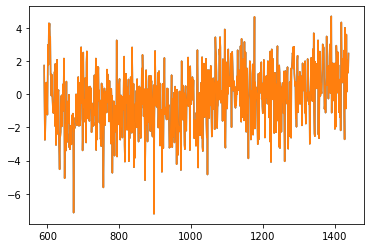

In [57]:
print(allmav.shape)
interval=np.array([1980,2010,2])
startyear=refdate.year
stop=interval[1]
start=interval[0]
stime=(start-startyear)*12
itime=stime+np.arange((stop-start+1)*12)
anomalies=np.empty_like(allmav)
anomalies.fill(np.nan)
climatologies=np.empty_like(allmav,shape=(*allmav.shape[0:3],12))
climatologies.fill(np.nan)
good=np.zeros(shape=(allmav.shape[0],allmav.shape[1],allmav.shape[2]),dtype=np.int32)
s=np.zeros_like(allmav,shape=(allmav.shape[0],1,3,allmav.shape[2]))#.fill(np.nan)
print(typeof(allmav),typeof(interval),typeof(itime),typeof(anomalies),
      typeof(climatologies),typeof(good),typeof(s))

anomalies_and_slopes(allmav,1900,interval,2,0,itime,anomalies,climatologies,good,s)
nj=18
ni=36
lons=np.array((16.)).reshape((1))
lats=np.array((48.)).reshape((1))
print(lats.shape)
glons=5.+10.*np.arange(ni)
glats=-85.+10.*np.arange(nj)
gstatindex=np.zeros([nj,ni,50],dtype=np.int) # 20 is max stations per 10x10 degree box
find_gstatindex(glons,glats,lons,lats,gstatindex)
ganomalies=np.zeros([nj,ni,2,allmav.shape[2],allmav.shape[3]],np.float32)
ganomalies.fill(np.nan)
gslopes=np.zeros([nj,ni,2,allmav.shape[2]],np.float32)
gslopes.fill(np.nan)
grid_anomalies(anomalies,good,int(3),gstatindex,ganomalies,gslopes,start,stop,itime)

print(ganomalies.shape)
idx=np.where(~np.isnan(ganomalies[:,:,0,0,1400]))
import matplotlib.pylab as plt
plt.plot(ganomalies[idx[0][0],idx[1][0],0,0,:])
plt.plot(anomalies[0,0,0,:])


In [ ]:
climatologies=np.empty_like(allmav,shape=(*allmav.shape[0:3],12)).fill(np.nan)

In [ ]:
climatologies.shape

In [ ]:
refdate.year

In [ ]:
import cffi

In [ ]:
dir(cffi)

In [ ]:
cffi.__version__